In [5]:
import numpy as np
import mdtraj as md
import nglview as nv
import matplotlib.pyplot as plt

import pyemma
import pickle
import torch
import lightning


from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward, Normalization
from mlcolvar.core.transform import Statistics
from matplotlib.colors import LogNorm
from tqdm import tqdm


np.bool = np.bool_
MLCV_DIM = 2

In [6]:
class MLCV(BaseCV, lightning.LightningModule):
    BLOCKS = ["norm_in", "encoder",]

    def __init__(
        self,
        encoder_layers: list,
        options: dict = None,
        **kwargs,
    ):
        super().__init__(in_features=encoder_layers[0], out_features=encoder_layers[-1], **kwargs)
        # ======= OPTIONS =======
        options = self.parse_options(options)
        
        # ======= BLOCKS =======
        # initialize norm_in
        o = "norm_in"
        if (options[o] is not False) and (options[o] is not None):
            self.norm_in = Normalization(self.in_features, **options[o])

        # initialize encoder
        o = "encoder"
        self.encoder = FeedForward(encoder_layers, **options[o])

In [7]:
save_path  = "/home/shpark/prj-mlcv/lib/bioemu/model/0701_0236/mlcv.pt"
model_state = torch.load(save_path)
print(model_state.keys())

mlcv_state_dict = model_state["mlcv_state_dict"]
# score_state_dict = model_state["model_state_dict"]

encoder_layers = [45, 30, 30, MLCV_DIM]
options = {
	"encoder": {
		"activation": "tanh",
		"dropout": [0.1, 0.1, 0.1]
	},
	"norm_in": {
	},
}
mlcv_model = MLCV(
	encoder_layers = encoder_layers,
	options = options
)

mlcv_model.load_state_dict(mlcv_state_dict)
print(mlcv_model)

dict_keys(['mlcv_state_dict'])
MLCV(
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=30, out_features=30, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=30, out_features=2, bias=True)
      (7): Dropout(p=0.1, inplace=False)
    )
  )
)


# Data

In [8]:
molecule = "CLN025"
simulation_idx = 0
simulation_num = 0
cln025_cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-switch.pt"
ca_distance_data = torch.load(cln025_cad_path)
print(ca_distance_data.shape)

torch.Size([530000, 45])


In [9]:
# Alpha carbon distances
pdb_path = "/home/shpark/prj-mlcv/lib/DESRES/data/CLN025.pdb"
state_traj = md.load(pdb_path)
ca_atoms = state_traj.topology.select("name CA")
n_atoms = len(ca_atoms)	
atom_pairs = []
for i in range(n_atoms):
    for j in range(i+1, n_atoms):
        atom_pairs.append([ca_atoms[i], ca_atoms[j]])
print(atom_pairs)

# Load traj data
for simulation_idx in range(simulation_num + 1):
	traj_list = []
	for i in tqdm(
		range(53),
		desc="Loading trajectories"
	):
		file_idx = f"{i:03d}"
		traj = md.load_dcd(
			f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-{simulation_idx}-protein/CLN025-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein-{file_idx}.dcd",
			top=pdb_path
		)
		traj_list.append(traj)
	all_traj = md.join(traj_list)

	feat_dist = pyemma.coordinates.featurizer(pdb_path)
	feat_dist.add_distances(indices=atom_pairs)
	feature_distances = feat_dist.transform(all_traj)
	feature_switch_distances = (1 - np.power(feature_distances / 0.8, 6)) / (1 - np.power(feature_distances / 0.8, 12))
	print(feature_switch_distances.shape)

[[np.int64(4), np.int64(25)], [np.int64(4), np.int64(46)], [np.int64(4), np.int64(60)], [np.int64(4), np.int64(72)], [np.int64(4), np.int64(87)], [np.int64(4), np.int64(101)], [np.int64(4), np.int64(108)], [np.int64(4), np.int64(122)], [np.int64(4), np.int64(146)], [np.int64(25), np.int64(46)], [np.int64(25), np.int64(60)], [np.int64(25), np.int64(72)], [np.int64(25), np.int64(87)], [np.int64(25), np.int64(101)], [np.int64(25), np.int64(108)], [np.int64(25), np.int64(122)], [np.int64(25), np.int64(146)], [np.int64(46), np.int64(60)], [np.int64(46), np.int64(72)], [np.int64(46), np.int64(87)], [np.int64(46), np.int64(101)], [np.int64(46), np.int64(108)], [np.int64(46), np.int64(122)], [np.int64(46), np.int64(146)], [np.int64(60), np.int64(72)], [np.int64(60), np.int64(87)], [np.int64(60), np.int64(101)], [np.int64(60), np.int64(108)], [np.int64(60), np.int64(122)], [np.int64(60), np.int64(146)], [np.int64(72), np.int64(87)], [np.int64(72), np.int64(101)], [np.int64(72), np.int64(108)], 

Loading trajectories: 100%|██████████| 53/53 [00:01<00:00, 33.85it/s]


(530000, 45)


In [10]:
descriptors = feature_switch_distances

descriptors_mean = descriptors.mean()
descriptors_std = descriptors.std()
descriptors_normalized = (descriptors - descriptors_mean) / descriptors_std

print(descriptors_normalized.shape)

(530000, 45)


In [11]:
with open(f'/home/shpark/prj-mlcv/lib/DESRES/data/CLN025_tica_model_switch.pkl', 'rb') as f:
    tica = pickle.load(f)
print(tica)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=5,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


# TICA

In [12]:
mlcv_model.eval()
cv = mlcv_model(torch.from_numpy(feature_switch_distances))
cv = cv.detach().cpu().numpy()
print(cv.shape)
print(cv.max(), cv.min())

(530000, 2)
0.17593992 -0.13895164


In [13]:
import torch
from mlcolvar.core.transform import Transform


def sanitize_range(range: torch.Tensor):
    """Sanitize

    Parameters
    ----------
    range : torch.Tensor
        range to be used for standardization

    """

    if (range < 1e-6).nonzero().sum() > 0:
        print(
            "[Warning] Normalization: the following features have a range of values < 1e-6:",
            (range < 1e-6).nonzero(),
        )
    range[range < 1e-6] = 1.0

    return range

class PostProcess(Transform):
    def __init__(
        self,
        stats = None,
        reference_frame_cv = None,
        feature_dim = 1,
    ):
        super().__init__(in_features=feature_dim, out_features=feature_dim)
        self.register_buffer("mean", torch.zeros(feature_dim))
        self.register_buffer("range", torch.ones(feature_dim))
        
        if stats is not None:
            min = stats["min"]
            max = stats["max"]
            self.mean = (max + min) / 2.0
            range = (max - min) / 2.0
            self.range = sanitize_range(range)
        
        if reference_frame_cv is not None:
            self.register_buffer(
                "flip_sign",
                torch.ones(1) * -1 if reference_frame_cv < 0 else torch.ones(1)
            )
        else:
            self.register_buffer("flip_sign", torch.ones(1))
        
    def forward(self, x):
        x = x.sub(self.mean).div(self.range)
        x = x * self.flip_sign
        
        return x


In [14]:
stats = Statistics(torch.from_numpy(cv).cpu()).to_dict()
mlcv_model.postprocessing = PostProcess(stats).to(mlcv_model.device)

In [15]:
postprocessed_cv = mlcv_model(torch.from_numpy(feature_switch_distances))
print(cv.max())
print(cv.min())
print(postprocessed_cv.max())
print(postprocessed_cv.min())

0.17593992
-0.13895164
tensor(1., grad_fn=<MaxBackward1>)
tensor(-1., grad_fn=<MinBackward1>)


(530000, 2)


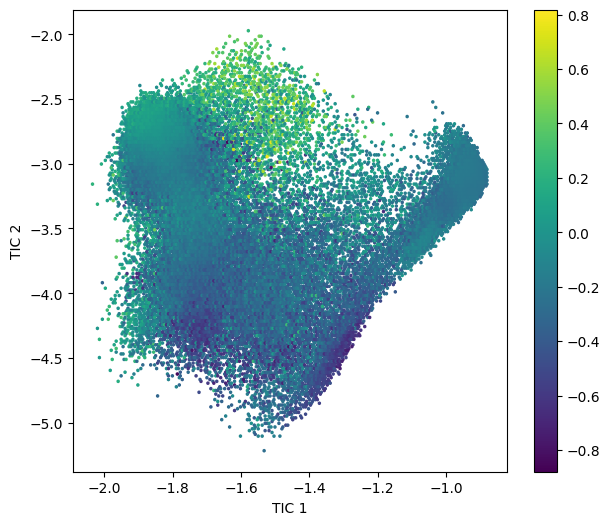

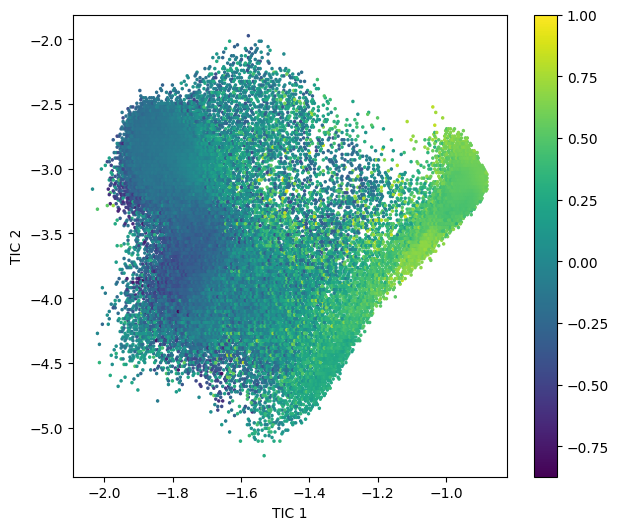

: 

In [21]:
tica_data = tica.transform(feature_switch_distances)
x = tica_data[:, 0]
y = tica_data[:, 1]
print(tica_data.shape)

# State information
# state_traj = md.load(pdb_path)
# state_feat = feat_dist.transform(state_traj)
# state_feat_switch = (1 - np.power(state_feat / 0.8, 6)) / (1 - np.power(state_feat / 0.8, 12))
# tica_state = tica_obj.transform(state_feat_switch)

# Plot
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
hb = ax.hexbin(
	x, y, C=postprocessed_cv[:, 0].detach().cpu().numpy(),  # data
	gridsize=200,                     # controls resolution
	reduce_C_function=np.mean,       # compute average per hexagon
	cmap='viridis',                  # colormap
)
plt.colorbar(hb)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
# plt.gca().invert_yaxis()
plt.show()

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
hb = ax.hexbin(
	x, y, C=postprocessed_cv[:, 1].detach().cpu().numpy(),  # data
	gridsize=200,                     # controls resolution
	reduce_C_function=np.mean,       # compute average per hexagon
	cmap='viridis',                  # colormap
)
plt.colorbar(hb)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
# plt.gca().invert_yaxis()
plt.show()

(1060000,)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 530000 but size of corresponding boolean axis is 1060000

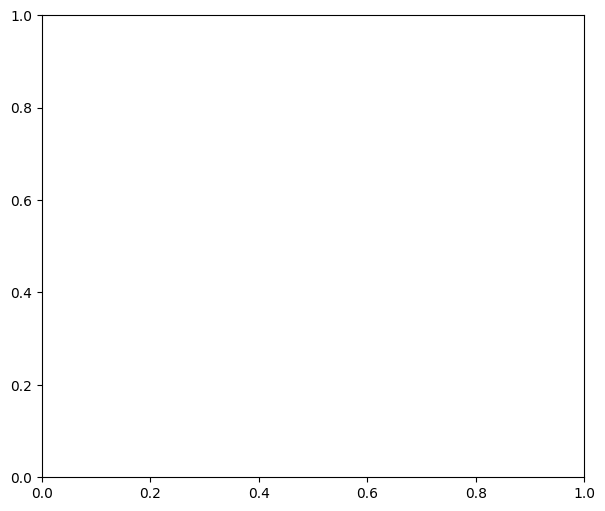

In [19]:
tica_data = tica.transform(feature_switch_distances)
x = tica_data[:, 0]
y = tica_data[:, 1]

ran = [
	[-1, -0.5],
	[-0.5, 0],
	[0, 0.5],
	[0.5, 1],
]
# Plot
for bound in ran:
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	mask  = (postprocessed_cv.detach().cpu().numpy() > bound[0]) & (postprocessed_cv.detach().cpu().numpy() < bound[1])
	mask = mask.reshape(-1)
	print(mask.shape)
	hb = ax.hexbin(
		x[mask], y[mask], C=postprocessed_cv.detach().cpu().numpy()[mask],  # data
		gridsize=200,                     # controls resolution
		reduce_C_function=np.mean,       # compute average per hexagon
		cmap='viridis',                  # colormap
		vmin=-1, vmax=1
	)
	plt.colorbar(hb)
	plt.xlabel("TIC 1")
	plt.ylabel("TIC 2")
	plt.xlim(-2.2, -0.8)
	plt.ylim(-5.5, -1.8)
	# plt.gca().invert_yaxis()
	plt.show()